In [1]:

# This allows changes in chakra.py to be automatically re-imported
# (this is tricky with OOP though, to be used with care)
%load_ext autoreload
%autoreload 1
%aimport chakra


In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import time,os
import xarray as xr
from scipy import stats

from oggm import cfg, utils, workflow, tasks, graphics
import oggm.cfg as cfg
from oggm import graphics
from oggm.core.massbalance import ScalarMassBalance
from oggm.core.flowline import FluxBasedModel
from oggm.tests.funcs import bu_tidewater_bed
# Get the default params
cfg.initialize(logging_level='WORKFLOW')
cfg.PARAMS['cfl_number'] = 0.01  # less numerical instabilities
cfg.PARAMS['use_multiprocessing'] = False


/home/ruitang/miniconda3/envs/oggm_env/lib/python3.8/site-packages/oggm/cfg.py:386: FutureWarning: In future versions of OGGM, the logging config WORKFLOW will no longer print ERROR or WARNING messages, but only high level information (i.e. hiding potential errors in your code but also avoiding cluttered log files for runs with many expected errors, e.g. global runs). If you want to obtain a similar logger behavior as before, set `logging_level='WARNING'`, which will print high level info as well as errors and warnings during the run. If you want to use the new behavior and suppress this warning, set `logging_level='WORKFLOW'` and `future=True`.
  warnings.warn(msg, category=FutureWarning)
2023-05-31 14:35:09: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-05-31 14:35:09: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-05-31 14:35:09: oggm.cfg: Multiprocessing: using all available processors (N=8)
2023-05-31 14:35:0

In [3]:
## Global constants
G = 9.8 # acceleration due to gravity in m/s^2
RHO_ICE = 920.0 #ice density kg/m^3
RHO_SEA = 1020.0 #seawater density kg/m^3

def tau_y(tau0=150e3, yield_type='constant', bed_elev=None, thick=None, mu=0.01):
    """Functional form of yield strength.
    Can do constant or Mohr-Coulomb yield strength.  Ideally, the glacier's yield type
    ('constant' or 'variable') would be saved in a model instance.

    Parameters
    ----------
    tau0: float, optional
        Initial guess for yield strength [Pa]. Default is 150 kPa.
    yield_type: str, optional
        'constant' or 'variable' (Mohr-Coulomb) yielding. Default is constant.
    bed_elev: float, optional
        Bed elevation, dimensional [m]. The default is None.
    thick: float, optional
        Ice thickness, dimensional [m]. The default is None.
    mu: float, optional
        Mohr-Coulomb cohesion, a coefficient between 0 and 1. Default is 0.01.

    Returns
    -------
    tau_y: float
        The yield strength for these conditions.
    """
    if yield_type=='variable':
        try:
            if bed_elev<0:
                D = -1*bed_elev #Water depth D the nondim bed topography value when Z<0
            else:
                D = 0
        except:
            print('You must set a bed elevation and ice thickness to use variable yield strength.')
        N = RHO_ICE*G*thick - RHO_SEA*G*D #Normal stress at bed
        ty = tau0 + mu*N
    else: #assume constant if not set
        ty = tau0
    return ty


def balance_thickness(yield_strength, bed_elev):
    """Ice thickness such that the stress matches the yield strength.

    Parameters
    ----------
    yield_strength: float
        The yield strength near the terminus.
        If yield type is constant, this will of course be the same everywhere.  If yield type is
        variable (Mohr-Coulomb), the yield strength at the terminus could differ from elsewhere.
    bed_elev: float
        Elevation of glacier bed at the terminus

    Returns
    -------
    Hy: float
        The ice thickness for stress balance at the terminus.
    """

    if bed_elev<0:
        D = -1*bed_elev
    else:
        D = 0
    return (2*yield_strength/(RHO_ICE*G)) + np.sqrt((RHO_SEA*(D**2)/RHO_ICE)+(2*yield_strength/(RHO_ICE*G)))
## TODO: Check on exponent on last term.  In Ultee & Bassis 2016, this is squared, but in Ultee & Bassis 2020 supplement, it isn't.



def fa_from_velocity(profile, model_velocity, terminus_mb=None, verbose=False,
                    tau0=150e3, yield_type='constant', mu=0.01,
                    trim_profile=0):
    """Compute frontal ablation given velocity forcing

    Parameters
    ----------
    profile: NDarray
        The current profile (x, surface, bed) as calculated by the base model
        Unlike core SERMeQ, these should be DIMENSIONAL [m].
    model_velocity: array
        Velocity along the flowline [m/a] as calculated by the base model
        Should have values for the points nearest the terminus...otherwise doesn't matter if this
        is the same shape as the profile array.
    terminus_mb : float, optional
        Mass balance nearest the terminus [m/a]. Default None...TODO: set default behavior
    verbose: Boolean, optional
        Whether to print component parts for inspection.  Default False.

    tau0: float, optional
        This glacier's yield strength [Pa]. Default is 150 kPa.
    yield_type: str, optional
        'constant' or 'variable' (Mohr-Coulomb) yielding. Default is constant.
    mu: float, optional
        Mohr-Coulomb cohesion, a coefficient between 0 and 1. Default is 0.01.
        Only used if we have variable yield

    trim_profile: int, optional
        How many grid cells at the end of the profile to ignore.  Default is 1.
        If the initial profile is set by k-calving (as in testing) there can be a
        weird cliff shape with very thin final grid point and large velocity gradient

    Returns
    -------
    fa_viscoplastic: float
        Frontal ablation rate [m/a] based on viscoplastic assumptions
    """
    last_index=-1*(trim_profile+1) ## remove lowest cells if needed

    ## Ice thickness and yield thickness nearest the terminus
    se_terminus = profile[1][last_index]
    bed_terminus = profile[2][last_index]
    H_terminus = se_terminus - bed_terminus
    tau_y_terminus = tau_y(tau0=tau0, bed_elev=bed_terminus, thick=H_terminus,yield_type=yield_type)
    Hy_terminus = balance_thickness(yield_strength=tau_y_terminus, bed_elev=bed_terminus)
    U_terminus = model_velocity[last_index] ## velocity, assuming last point is terminus

    ## Ice thickness and yield thickness at adjacent point
    se_adj = profile[1][last_index-1]
    bed_adj = profile[1][last_index-1]
    H_adj = se_adj - bed_adj
    tau_y_adj = tau_y(tau0=tau0,bed_elev=bed_adj, thick=H_adj,yield_type=yield_type)
    Hy_adj = balance_thickness(yield_strength=tau_y_adj, bed_elev=bed_adj)
    U_adj = model_velocity[last_index-1]


    # Gradients
    dx_term = abs(profile[0][last_index-1] - profile[0][last_index]) ## check grid spacing close to terminus
    dHdx = (H_terminus-H_adj)/dx_term
    dHydx = (Hy_terminus-H_adj)/dx_term
    dUdx = (U_terminus-U_adj)/ dx_term ## velocity gradient


    ## Group the terms
    dLdt_numerator = terminus_mb - (H_terminus * dUdx) - (U_terminus * dHdx)
    dLdt_denominator = dHydx - dHdx ## TODO: compute dHydx
    dLdt_viscoplastic = dLdt_numerator / dLdt_denominator

    fa_viscoplastic = U_terminus - dLdt_viscoplastic ## frontal ablation rate

    if verbose:
        print('For inspection on debugging - all should be DIMENSIONAL (m/a):')
#         print('profile_length={}'.format(profile_length))
        print('se_terminus={}'.format(se_terminus))
        print('bed_terminus={}'.format(bed_terminus))
        print('Thicknesses: Hterm {}, Hadj {}'.format(H_terminus, H_adj))
        print('Hy_terminus={}'.format(Hy_terminus))
        print('U_terminus={}'.format(U_terminus))
        print('dx_term={}'.format(dx_term))
        print('Checking dLdt: terminus_mb = {}. \n H dUdx = {}. \n U dHdx = {}.'.format(terminus_mb, dUdx*H_terminus, U_terminus*dHdx))
        print('Denom: dHydx = {} \n dHdx = {}'.format(dHydx, dHdx))
        print('Viscoplastic dLdt={}'.format(dLdt_viscoplastic))
    else:
        pass

    return fa_viscoplastic


In [4]:
# set the output/result folder
rgi_id = 'RGI60-01.17876'
Figpath='/home/ruitang/Astra_Ruitang_UIO/Frontal_Ablation_Global/Results/Steadystate_Tests_on_Sermeq_Bubed'
Figpath_Folder_tif_path=Figpath+'/Tif/'+rgi_id+'/'
Figpath_Folder_png_path=Figpath+'/Png/'+rgi_id+'/'
Figpath_Folder_tif=utils.mkdir(Figpath_Folder_tif_path,reset=True)
Figpath_Folder_png=utils.mkdir(Figpath_Folder_png_path,reset=True)

# 1. Steadystate test

## 1.1 get the present time glacier profile information from OGGM dataset?

2023-05-31 14:35:09: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2023-05-31 14:35:09: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


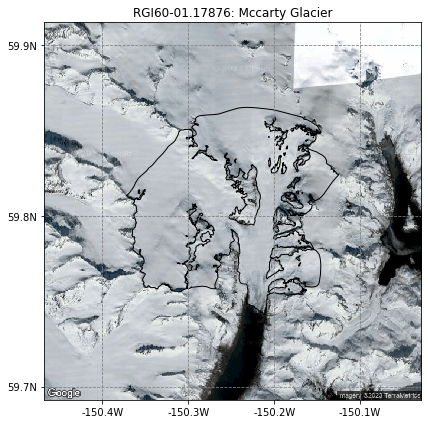

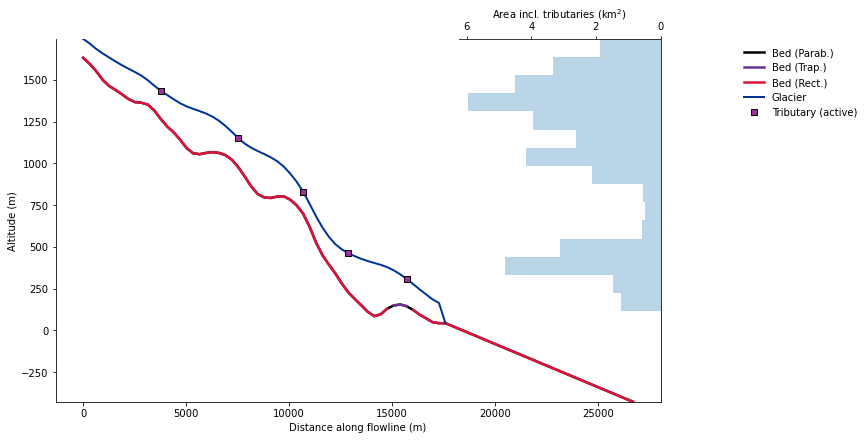

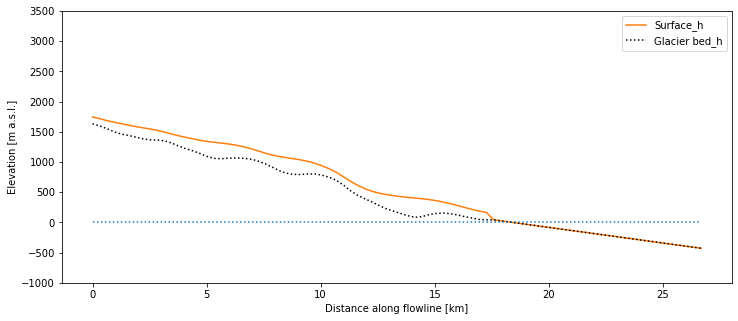

In [5]:
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-Calving', reset=True)
cp_dir = os.path.join(cfg.PATHS['working_dir'], 'calving')
# Download from the "OGGM shop"
gdir_woc = workflow.init_glacier_directories([rgi_id], from_prepro_level=3, prepro_border=80)[0]
tasks.init_present_time_glacier(gdir_woc)

######################################## get the glacier topography
graphics.plot_googlemap(gdir_woc, figsize=(6,6));
# save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'Topography'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'Topography'+'.png',dpi=600,bbox_inches='tight')

######################################## glacier profile with area distribution histogram
# get the glacier profile along the flowline(main centerline) and area histogram
bu_fl = gdir_woc.read_pickle('model_flowlines')[-1]
graphics.plot_modeloutput_section([bu_fl])
#save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'Glacier_profile_AreaHist'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'Glacier_profile_AreaHist'+'.png',dpi=600,bbox_inches='tight')

######################################## glacier profile
xc = bu_fl.dis_on_line * bu_fl.map_dx / 1000
f, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(xc, bu_fl.surface_h, '-', color='C1', label='Surface_h')
ax.plot(xc, bu_fl.bed_h, ':', color='k', label='Glacier bed_h')
plt.hlines(0, *xc[[0, -1]], color='C0', linestyles=':')
plt.ylim(-1000, 3500); plt.ylabel('Elevation [m a.s.l.]'); plt.xlabel('Distance along flowline [km]');
plt.legend();
#save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'Glacier_profile'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'Glacier_profile'+'.png',dpi=600,bbox_inches='tight')

## 1.2 Put a k-calving profile on top of this and check what viscoplastic calving rates we’d get

7.733836775587345


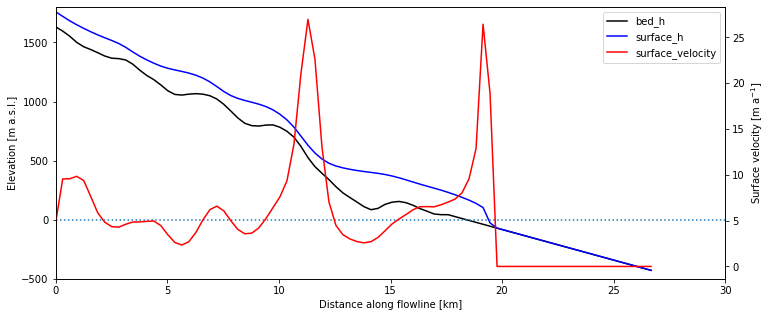

In [6]:
mb_model = ScalarMassBalance()
no_mb = ScalarMassBalance()
model = FluxBasedModel(bu_fl, mb_model=mb_model,
                       is_tidewater=True,
                       calving_use_limiter=True,  # default is True
                       flux_gate=0.06,  # default is 0
                       calving_k=0.2,  # default is 2.4
                       do_kcalving=True
                      )
# long enough to reach approx. equilibrium
ds = model.run_until_and_store(6000)
df_diag = model.get_diagnostics()
print(model.calving_rate_myr) #print the k-calving calving rate
######################################## get the steadystate glacier profile
plt.figure(1,figsize=(12, 5))
ax=plt.subplot(1,1,1)
xlim0=0;xlim1=(max(xc)//10+1)*10
ylim0=(min(df_diag.bed_h)//100)*100;ylim1=(max(df_diag.surface_h)//100+1)*100
lns1,=ax.plot(xc, df_diag.bed_h, color='k',label='bed_h')
lns2,=ax.plot(xc, df_diag.surface_h, color='b',label='surface_h')
plt.hlines(0, xlim0,xlim1, color='C0', linestyles=':')
plt.xlim(xlim0, xlim1);plt.ylim(ylim0, ylim1); plt.ylabel('Elevation [m a.s.l.]');plt.xlabel('Distance along flowline [km]')
ax2=ax.twinx()
lns3,=ax2.plot(xc, df_diag.ice_velocity*cfg.SEC_IN_YEAR, color='r',label='surface_velocity')
plt.ylabel('Surface velocity [m a$^{-1}$]')
legend_profile=plt.legend(handles=[lns1,lns2,lns3],loc='upper right')
#save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'Glacier_profile_velocity'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'Glacier_profile_velocity'+'.png',dpi=600,bbox_inches='tight')

## 1.3 Calculate Sermeq frontal ablation

In [7]:
# prepare the input
surface_profile = df_diag.surface_h
bed_profile = df_diag.bed_h
x = df_diag.index
model_U = df_diag.ice_velocity * cfg.SEC_IN_YEAR ## convert ice velocity to m/a
## Find index of the terminus
term_index = int(np.argwhere(surface_profile.values>0)[-1])

input_profile = (x.values[:term_index+1], ## slice up to index+1 to include the last nonzero value
                 surface_profile.values[:term_index+1],
                 bed_profile.values[:term_index+1])
input_velocity = model_U.values[:term_index+1]
no_mb.get_annual_mb(heights=surface_profile.values[0])
testval = fa_from_velocity(profile=input_profile, model_velocity=input_velocity, terminus_mb=0, verbose=False,
                    tau0=150e3, yield_type='constant', mu=0.01)
print(testval)  #print the sermeq frontal ablation

-57.859361076385056


## 1.4 Tests on the effect of yield strength, massbalance, and velocity scale

108
108


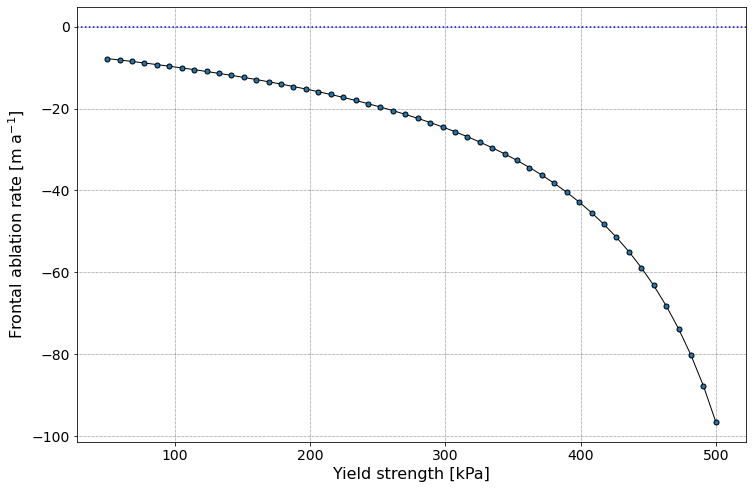

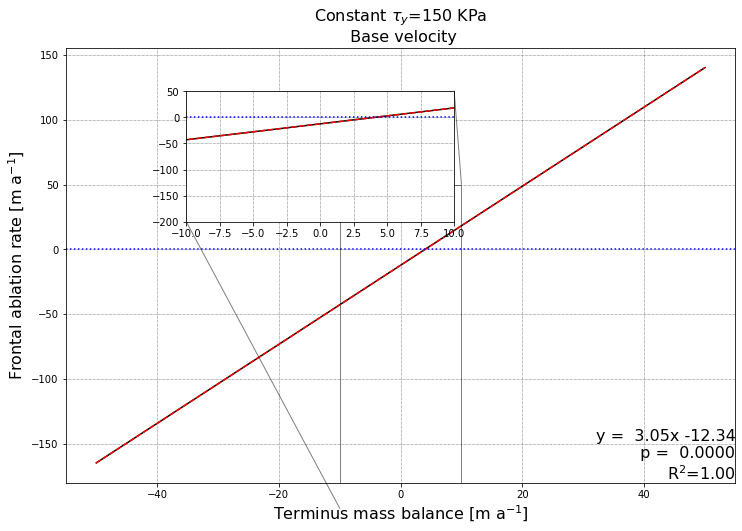

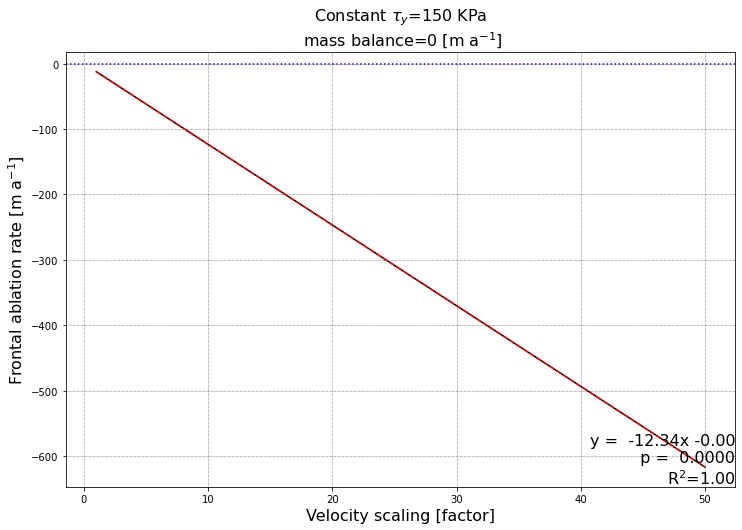

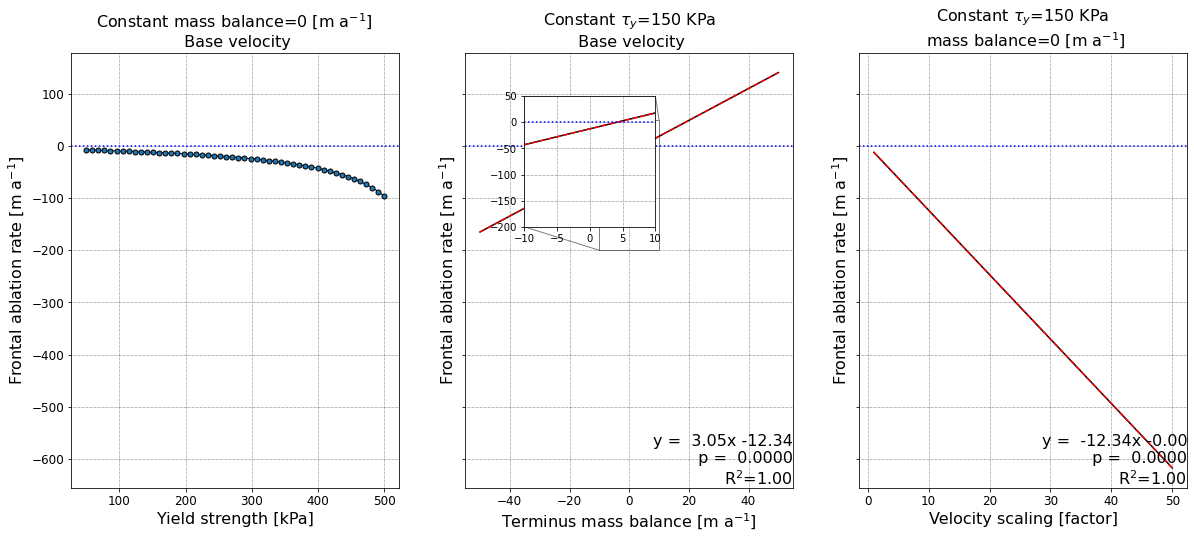

In [8]:
########################################  test on the effect of yield strength
ty_tests = np.linspace(50e3, 500e3, num=50)
fa_results = [fa_from_velocity(profile=input_profile, model_velocity=input_velocity, terminus_mb=0, verbose=False,
                               tau0=ty, yield_type='constant', mu=0.01, trim_profile=1) for ty in ty_tests]
#####plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(1e-3*ty_tests, fa_results,color='k', linestyle='-', linewidth=1,marker='o', markersize=5,markeredgecolor='black', markerfacecolor='C0')
plt.xlabel('Yield strength [kPa]',fontsize=16)
plt.ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=16)
plt.grid(color = 'k', linestyle = ':', linewidth = 0.5)
ax.axhline(0, color='b', ls=':')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.spines["top"].set_color('k')
ax.spines["bottom"].set_color('k')
ax.spines["left"].set_color('k')
ax.spines["right"].set_color('k')
# Find index of the terminus where the frontal ablation change to positive
if (np.array(fa_results)>0).any():
    term_Posi_FA_index = int(np.argwhere(np.array(fa_results)>0)[0])
    print(term_Posi_FA_index)
    # insert the subplot
    axins = ax.inset_axes((0.15,0.4, 0.4, 0.5))
    axins.plot(1e-3*ty_tests, fa_results,color='k', linestyle='-', linewidth=1,marker='o', markersize=5,markeredgecolor='black', markerfacecolor='C0')
    axins.grid(color = 'k', linestyle = ':', linewidth = 0.5)
    axins.axhline(0, color='b', ls=':')
    axins.spines["top"].set_color('k')
    axins.spines["bottom"].set_color('k')
    axins.spines["left"].set_color('k')
    axins.spines["right"].set_color('k')
    # set the axis limit of the subregion
    xlim0 = 40;xlim1 =1e-3*ty_tests[term_Posi_FA_index] ; ylim0 = ((min(fa_results))//50)*50; ylim1 = 50;
    axins.set_xlim(xlim0, xlim1)
    axins.set_ylim(ylim0, ylim1)
    # set the connection line between the main and the subregion
    ax.indicate_inset_zoom(axins, edgecolor="r")
#save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'Yeild strength on Fa'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'Yeild strength on Fa'+'.png',dpi=600,bbox_inches='tight')



########################################  test on the effect of massbalance
mb_tests = np.linspace(-50, 50, num=200)
fa_results_mb = [fa_from_velocity(profile=input_profile, model_velocity=input_velocity, terminus_mb=mb, verbose=False,
                                  tau0=150e3, yield_type='constant', mu=0.01, trim_profile=1) for mb in mb_tests]


# do the linear regression
fa_results_mb_LF = stats.linregress(mb_tests, fa_results_mb)
k_mb = fa_results_mb_LF.slope
b_mb = fa_results_mb_LF.intercept
r2_mb = (fa_results_mb_LF.rvalue) ** 2
p_mb = fa_results_mb_LF.pvalue

#####plot
fig, ax2 = plt.subplots(1, 1, figsize=(12, 8))
ax2.plot(mb_tests, fa_results_mb,'k',mb_tests, k_mb*mb_tests+b_mb,'--r')
plt.grid(color = 'k', linestyle = ':', linewidth = 0.5)
ax2.axhline(0, color='b', ls=':')
ax2.set_title(r'Constant $\tau_y$=150 KPa' + '\n Base velocity',fontsize=16)
ax2.annotate('y = '  + ' {:.2f}'.format(k_mb) + 'x '+ '{:.2f}'.format(b_mb)+
         '\n p = ' +' {:.4f}'.format(p_mb) +
         '\n R$^{2}$=' + '{:.2f}'.format(r2_mb),
             xy=(1, 0),xycoords='axes fraction', fontsize=16, horizontalalignment='right', verticalalignment='bottom')
ax2.set_xlabel('Terminus mass balance [m a$^{-1}$]',fontsize=16)
ax2.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=16)
if (np.array(fa_results_mb)>0).any():
    term_Posi_FA_index_mb = int(np.argwhere(np.array(fa_results_mb)>0)[0]) # Find index of the terminus
    print(term_Posi_FA_index_mb)
    # insert the subplot
    axins2 = ax2.inset_axes((0.18,0.6, 0.4, 0.3))
    axins2.plot(mb_tests, fa_results_mb,'k',mb_tests, k_mb*mb_tests+b_mb,'--r')
    axins2.grid(color = 'k', linestyle = ':', linewidth = 0.5)
    axins2.spines["top"].set_color('k')
    axins2.spines["bottom"].set_color('k')
    axins2.spines["left"].set_color('k')
    axins2.spines["right"].set_color('k')
    # set the axis limit of the subregion
    xlim0 = -10;xlim1 =10 ;ylim0 = -200; ylim1 = 50;#xlim1 =1e-3*mb_tests[term_Posi_FA_index_mb+5]
    axins2.set_xlim(xlim0, xlim1)
    axins2.set_ylim(ylim0, ylim1)
    axins2.axhline(0, color='b', ls=':')
    axins2.legend_=None
    # set the connection line between the main and the subregion
    ax2.indicate_inset_zoom(axins2, edgecolor="k")
#save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'Massbalance on Fa'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'Massbalance on Fa'+'.png',dpi=600,bbox_inches='tight')



########################################  test on the effect of velocity scale
#We know our glacier is moving slowly.What does the frontal ablation rate look like if we scale up the velocity?
v_scalings = np.linspace(1, 50, num=50)
fa_results_v = [
    fa_from_velocity(profile=input_profile, model_velocity=v * np.asarray(input_velocity), terminus_mb=0, verbose=False,
                     tau0=150e3, yield_type='constant', mu=0.01, trim_profile=1) for v in v_scalings]
# do the linear regression
fa_results_v_LF = stats.linregress(v_scalings, fa_results_v)
k_v = fa_results_v_LF.slope
b_v = fa_results_v_LF.intercept
r2_v = (fa_results_v_LF.rvalue) ** 2
p_v = fa_results_v_LF.pvalue
#####plot
fig, ax3 = plt.subplots(1, 1, figsize=(12, 8))
ax3.plot(v_scalings, fa_results_v,'k',v_scalings, k_v*v_scalings+b_v,'--r')
ax3.set_title(r'Constant $\tau_y$=150 KPa' + '\n mass balance=0 [m a$^{-1}$]',fontsize=16)
ax3.axhline(0, color='b', ls=':')
ax3.grid(color = 'k', linestyle = ':', linewidth = 0.5)
#add fitted regression equation to plot
ax3.annotate('y = '  + ' {:.2f}'.format(k_v) + 'x '+ '{:.2f}'.format(b_v)+
         '\n p = ' +' {:.4f}'.format(p_v) +
         '\n R$^{2}$=' + '{:.2f}'.format(r2_v),
             xy=(1, 0),xycoords='axes fraction', fontsize=16, horizontalalignment='right', verticalalignment='bottom')
ax3.set_xlabel('Velocity scaling [factor]',fontsize=16)
ax3.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=16)
#save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'Velodity scale on Fa'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'Velodity scale on Fa'+'.png',dpi=600,bbox_inches='tight')



########################################
########################################
########################################  Put all the three tests together, comparing clearly
fig, (ax1, ax2,ax3) = plt.subplots(1,3,sharey=True, figsize=(20,8))
############### yeild strength
ax1.plot(1e-3*ty_tests, fa_results,color='k', linestyle='-', linewidth=1,marker='o', markersize=5,markeredgecolor='black', markerfacecolor='C0')
ax1.set_title("Constant mass balance=0 [m a$^{-1}$] \n Base velocity",fontsize=16)
ax1.set_xlabel('Yield strength [kPa]',fontsize=16)
ax1.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=16)
if (np.array(fa_results)>0).any():
    term_Posi_FA_index = int(np.argwhere(np.array(fa_results)>0)[0])
    print(term_Posi_FA_index)
    # insert the subplot
    axins = ax1.inset_axes((0.18,0.6, 0.4, 0.3))
    axins.plot(1e-3*ty_tests, fa_results,color='k', linestyle='-', linewidth=1,marker='o', markersize=5,markeredgecolor='black', markerfacecolor='C0')
    axins.grid(color = 'k', linestyle = ':', linewidth = 0.5)
    axins.spines["top"].set_color('k')
    axins.spines["bottom"].set_color('k')
    axins.spines["left"].set_color('k')
    axins.spines["right"].set_color('k')
    # set the axis limit of the subregion
    xlim0 = 40;xlim1 =1e-3*ty_tests[term_Posi_FA_index] ; ylim0 = ((min(fa_results))//50)*50; ylim1 = 50;
    axins.set_xlim(xlim0, xlim1)
    axins.set_ylim(ylim0, ylim1)
    # axins.set_xlabel('Yield strength [kPa]',fontsize=11)
    # axins.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=11)
    # set the connection line between the main and the subregion
    axins.axhline(0, color='b', ls=':')
    axins.legend_=None
    ax1.indicate_inset_zoom(axins, edgecolor="k")

############### mass balance
# subplot2
ax2.plot(mb_tests, fa_results_mb,'k',mb_tests, k_mb*mb_tests+b_mb,'--r')
ax2.set_title(r'Constant $\tau_y$=150 KPa' + '\n Base velocity',fontsize=16)
#add fitted regression equation to plot
ax2.annotate('y = '  + ' {:.2f}'.format(k_mb) + 'x '+ '{:.2f}'.format(b_mb)+
         '\n p = ' +' {:.4f}'.format(p_mb) +
         '\n R$^{2}$=' + '{:.2f}'.format(r2_mb),
             xy=(1, 0),xycoords='axes fraction', fontsize=16, horizontalalignment='right', verticalalignment='bottom')
ax2.set_xlabel('Terminus mass balance [m a$^{-1}$]',fontsize=16)
ax2.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=16)
if (np.array(fa_results_mb)>0).any():
    term_Posi_FA_index_mb = int(np.argwhere(np.array(fa_results_mb)>0)[0]) # Find index of the terminus
    print(term_Posi_FA_index_mb)
    # insert the subplot
    axins2 = ax2.inset_axes((0.18,0.6, 0.4, 0.3))
    axins2.plot(mb_tests, fa_results_mb,'k',mb_tests, k_mb*mb_tests+b_mb,'--r')
    axins2.grid(color = 'k', linestyle = ':', linewidth = 0.5)
    axins2.spines["top"].set_color('k')
    axins2.spines["bottom"].set_color('k')
    axins2.spines["left"].set_color('k')
    axins2.spines["right"].set_color('k')
    # set the axis limit of the subregion
    xlim0_2 = -10;xlim1_2 =10;ylim0_2= -200; ylim1_2 = 50;#xlim1 =1e-3*mb_tests[term_Posi_FA_index_mb]
    axins2.set_xlim(xlim0_2, xlim1_2)
    axins2.set_ylim(ylim0_2, ylim1_2)
    axins2.axhline(0, color='b', ls=':')
    axins2.legend_=None
    # set the connection line between the main and the subregion
    ax2.indicate_inset_zoom(axins2, edgecolor="k")

############### velocity scaling
#subplot3
ax3.plot(v_scalings, fa_results_v,'k',v_scalings, k_v*v_scalings+b_v,'--r')
ax3.set_title(r'Constant $\tau_y$=150 KPa' + '\n mass balance=0 [m a$^{-1}$]',fontsize=16)
#add fitted regression equation to plot
ax3.annotate('y = '  + ' {:.2f}'.format(k_v) + 'x '+ '{:.2f}'.format(b_v)+
         '\n p = ' +' {:.4f}'.format(p_v) +
         '\n R$^{2}$=' + '{:.2f}'.format(r2_v),
             xy=(1, 0),xycoords='axes fraction', fontsize=16, horizontalalignment='right', verticalalignment='bottom')
ax3.set_xlabel('Velocity scaling [factor]',fontsize=16)
ax3.set_ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=16)


# set the figure properites
for ax in (ax1,ax2,ax3):
    #ax.legend(loc='upper left')
    ax.spines["top"].set_color('k')
    ax.spines["bottom"].set_color('k')
    ax.spines["left"].set_color('k')
    ax.spines["right"].set_color('k')
    ax.grid(True,color = 'k', linestyle = ':', linewidth = 0.5)
    ax.axhline(0, color='b', ls=':')
    ax.fontsize=16
    ax.tick_params(labelsize=12)
# #save the figure
plt.savefig(Figpath_Folder_tif_path+rgi_id+'YieldS_MB_Velodity on Fa'+'.tif',dpi=600,bbox_inches='tight')
plt.savefig(Figpath_Folder_png_path+rgi_id+'YieldS_MB_Velodity on Fa'+'.png',dpi=600,bbox_inches='tight')